In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image
import h5py
import numpy as np

In [ ]:
BATCH_SIZE=16
LR=0.0002
BETAS=(0.5,0.999)
NUM_EPOCHS=10
z_dim=200

In [39]:
class CUBTextImageDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_folders = sorted(os.listdir(image_dir))

    def __len__(self):
        return sum([len(os.listdir(os.path.join(self.image_dir, folder))) for folder in self.image_folders])

    def __getitem__(self, idx):
        folder_idx = 0
        while idx >= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx]))):
            idx -= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx])))
            folder_idx += 1
        
        image_folder = self.image_folders[folder_idx]
        image_file = sorted(os.listdir(os.path.join(self.image_dir, image_folder)))[idx]
        image_path = os.path.join(self.image_dir, image_folder, image_file)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        base_name = os.path.splitext(image_file)[0]
        txt_path = os.path.join(self.text_dir, image_folder, base_name + ".txt")
        with open(txt_path, 'r') as file:
            txt_description = file.read().strip()
        return image, txt_description


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
image_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'
text_dir = '/kaggle/input/cub2002011/cvpr2016_cub/text_c10'

In [46]:
dataset = CUBTextImageDataset(image_dir=image_dir, text_dir=text_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    print("Batch of Images:", images.shape)
    print("Batch of Text Descriptions:", descriptions[0])
    description_list = descriptions[0].split('\n')
    print(len(description_list))
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions: a medium sized bird that is entirely black from beak to tail.
the bird has a black bill, black eyering and black thighs.
the bird is black with a black beak and black feet and tarsals.
this bird is completely black with a short pointy bill.
a small black bird with a black beak and feet.
this bird has wings that are black and has a thick bill
this particular bird has a belly that is black with dark blue secondaries
this bird is in pitch black color through out the body
this bird has wings that are black and has a thick bill
the bird is all black, including its tail, beak, legs and eyes.
10


In [34]:
def get_noise(BATCH_SIZE, z_dim, device='cpu'):
    return torch.randn(BATCH_SIZE, z_dim,1,1).to(device) 

In [5]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(image_filename, fontsize=8)

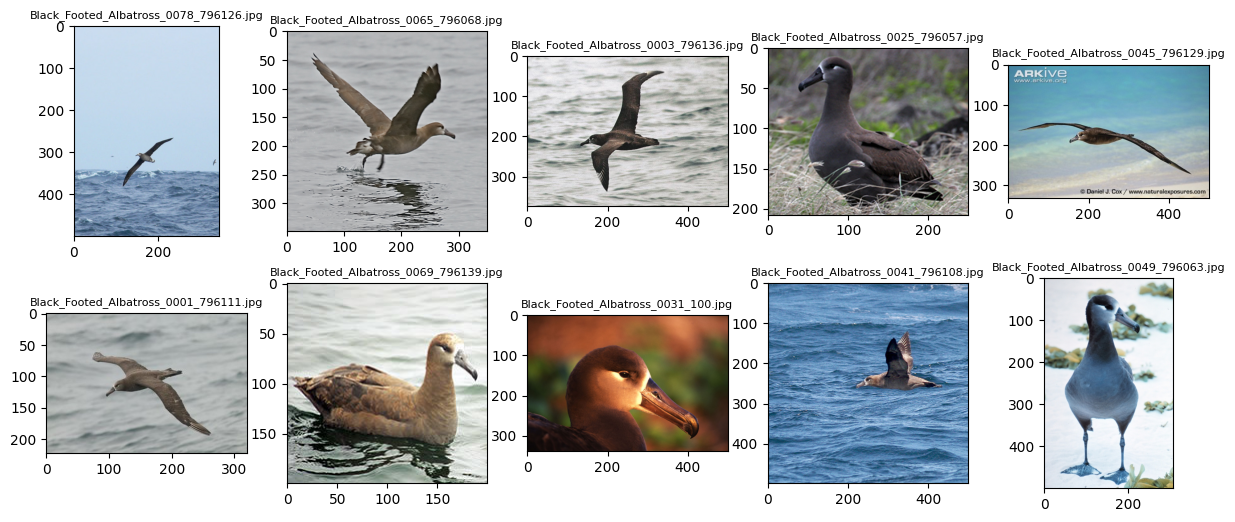

In [6]:
Black_footed_Albatross_dir='/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross'
visualize_images(Black_footed_Albatross_dir)

In [8]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,Gen=True,drop=False,norm=True,act='relu',kernel_size=3,stride=1,padding=1):
        super(ConvBlock,self).__init__()
        self.drop=drop
        self.norm=norm
        self.Gen=Gen
        self.dropout = nn.Dropout2d(0.5)
        self.act = act
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding) if Gen else nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels) if norm else nn.Identity(),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        if self.drop:
            x = self.dropout(x)
        return self.block(x)

In [64]:
class generator1(nn.Module):
    def __init__(self):
        super(generator1, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.noise_dim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = 64

        self.projection = nn.Sequential(
        nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
        nn.BatchNorm1d(num_features=self.projected_embed_dim),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        #  based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netG = nn.Sequential(
        nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(self.ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (num_channels) x 64 x 64
            )
        
    def forward(self, embed_vector, z):
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        latent_vector = torch.cat([projected_embed, z], 1)
        output = self.netG(latent_vector)

        return output

In [65]:
gen2=generator1()

In [66]:
gen2(embed,img)

RuntimeError: running_mean should contain 4 elements not 128

In [57]:
class Generator(nn.Module):
    def __init__(self,embed_dim=1024,z_dim=100,num_channels=3,hidden_dim=32):
        super(Generator, self).__init__()
        self.linear=nn.Sequential(
            nn.Linear(embed_dim,128),
#             nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = ConvBlock(z_dim,hidden_dim*16,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim*16,hidden_dim*8,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*8,hidden_dim*4,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*2,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*2,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv6 = ConvBlock(hidden_dim,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv7 = ConvBlock(hidden_dim,num_channels,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.tanh=nn.Tanh()
    
    def forward(self,x,label):
        embed=self.linear(label).unsqueeze(2)
        print(embed.shape)
        latent_z=torch.cat([embed,x],dim=1)
        x = self.conv1(latent_z)
        print(x.shape) #    torch.Size([1, 512, 2, 2])
        x = self.conv2(x)
        print(x.shape) #    torch.Size([1, 256, 4, 4])
        x = self.conv3(x)
        print(x.shape) #    torch.Size([1, 128, 8, 8])
        x = self.conv4(x)
        print(x.shape) #    torch.Size([1, 64, 16, 16])
        x = self.conv5(x)
        print(x.shape) #    torch.Size([1, 32, 32, 32])
        x = self.conv6(x)
        print(x.shape) #    torch.Size([1, 32, 64, 64])
        x = self.conv7(x)
        print(x.shape) #    torch.Size([1, 3, 128, 128])
        return self.tanh(x)

In [58]:
gen=Generator()

In [59]:
embed=torch.rand(1,4,1024)
img=torch.rand(1,3,128,128)
gen(img,embed)

torch.Size([1, 4, 1, 128])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 128 for tensor number 1 in the list.

In [54]:
img=get_noise(1,200)
gen(img)

torch.Size([1, 512, 2, 2])
torch.Size([1, 256, 4, 4])
torch.Size([1, 128, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 3, 128, 128])


tensor([[[[0.0000, 0.2190, 0.0000,  ..., 0.0846, 0.0093, 0.1676],
          [0.2471, 0.0000, 0.1882,  ..., 0.1451, 0.1633, 0.0276],
          [0.0000, 0.2494, 0.0000,  ..., 0.2100, 0.0446, 0.1988],
          ...,
          [0.2052, 0.0946, 0.3948,  ..., 0.3003, 0.1081, 0.0252],
          [0.0000, 0.1502, 0.0167,  ..., 0.0797, 0.0000, 0.2049],
          [0.0677, 0.0000, 0.1856,  ..., 0.0000, 0.1092, 0.0000]],

         [[0.0000, 0.0571, 0.0000,  ..., 0.0544, 0.0000, 0.0518],
          [0.0000, 0.2567, 0.0000,  ..., 0.1036, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0712, 0.0000,  ..., 0.0670, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0522,  ..., 0.0000, 0.0269, 0.0000]],

         [[0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2055,  ..., 0

In [11]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim=1024, projected_embed_dim=128):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=1024, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat


In [47]:
class Discriminator(nn.Module):
#     embed_dim=1024,z_dim=100,num_channels=3,hidden_dim=32
    def __init__(self,embed_dim=1024,in_channels=3,hidden_dim=64):
        super(Discriminator,self).__init__()
        self.conv1 = ConvBlock(in_channels,hidden_dim,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim,hidden_dim*2,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*2,hidden_dim*4,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*8,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*8,hidden_dim*16,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv6 = ConvBlock(hidden_dim*16,1,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv7 = ConvBlock(hidden_dim,3,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.projector=nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=128),
#             nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(0.2)
        )
        self.conv7=nn.Sequential(
            nn.Conv2d(hidden_dim*16*2,1,4,2,1),
            nn.Sigmoid()
        )
    
    
    def forward(self,x,embed):
        x=self.conv1(x)
        print(x.shape)
        x=self.conv2(x)
        print(x.shape)
        x=self.conv3(x)
        print(x.shape)
        x=self.conv4(x)
        print(x.shape)
        x_intermediate=self.conv5(x)
        print(x_intermediate.shape)
#         projected_embed=self.projector(embed)
#         print(projected_embed.shape)
        replicated_embed = embed.repeat(1,4, 1, 1).permute(0,3,1,2)
#         print
        print(replicated_embed.shape)
        x = torch.cat([x_intermediate, replicated_embed], dim=1)
        x=self.conv7(x)
        x=x.view(-1,1).squeeze(1)
        return x,x_intermediate

In [48]:
disc=Discriminator()

In [43]:
embed=torch.rand(1,4,1024)
embed=embed.repeat(1,4,1,1).permute(0,3,1,2)
embed.shape

torch.Size([1, 1024, 4, 4])

In [49]:
embed=torch.rand(1,4,1024)
img=torch.rand(1,3,128,128)
disc(img,embed)

torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 1024, 4, 4])


(tensor([0.5921, 0.5667, 0.4753, 0.5041], grad_fn=<SqueezeBackward1>),
 tensor([[[[-0.1138,  1.3626,  0.6548,  0.7655],
           [-0.1921,  1.3476, -0.3013, -0.2581],
           [-0.0479,  0.8804, -0.1945,  0.3457],
           [-0.2259,  1.1779,  0.9502, -0.1634]],
 
          [[ 0.3838,  1.3738,  1.1211,  1.0090],
           [ 0.0334, -0.0457, -0.2635, -0.0128],
           [-0.4163,  0.3546, -0.0114, -0.0900],
           [-0.0118,  0.9673, -0.3746,  0.8865]],
 
          [[-0.1773,  0.2135, -0.1975, -0.2078],
           [ 0.7994,  0.4795, -0.1845,  0.1821],
           [ 2.3173,  1.3603,  0.5469, -0.2570],
           [-0.2075,  0.9042, -0.0228, -0.1062]],
 
          ...,
 
          [[ 0.8454,  0.4493,  1.6725, -0.2943],
           [ 0.6208,  0.4380,  0.5467, -0.0309],
           [ 1.6053, -0.3436, -0.1967, -0.1701],
           [ 0.0669,  0.6769, -0.1552, -0.1935]],
 
          [[ 1.6690,  1.1535, -0.2424,  0.0446],
           [-0.1643, -0.0738, -0.1003, -0.0811],
           [ 1.567